In [1]:
![image.png](attachment:image.png)

'[image.png]' is not recognized as an internal or external command,
operable program or batch file.


This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images. 

## Preparation of the data

Import libraries

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

Chúng tôi hiển thị các tập tin trong tiết mục Kaggle:

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

We create the variable X containing all the images of cars by resizing them.



In [4]:
IMAGE_SIZE = 224

In [5]:
img_dir = "images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() 
#Chúng tôi sắp xếp các hình ảnh theo thứ tự bảng chữ cái để khớp chúng với các tệp xml chứa chú thích của các hộp giới hạn
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [6]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [7]:
path = 'annotations'
text_files = ['annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [8]:
resizeannotation("annotations/Cars147.xml")

[188, 141, 101, 104]

In [9]:
y[0]

[187, 144, 101, 104]

We check X et y shape

In [10]:
np.array(X).shape

(433, 224, 224, 3)

In [11]:
np.array(y).shape

(433, 4)

And we display the first eighteen image of the dataset : 

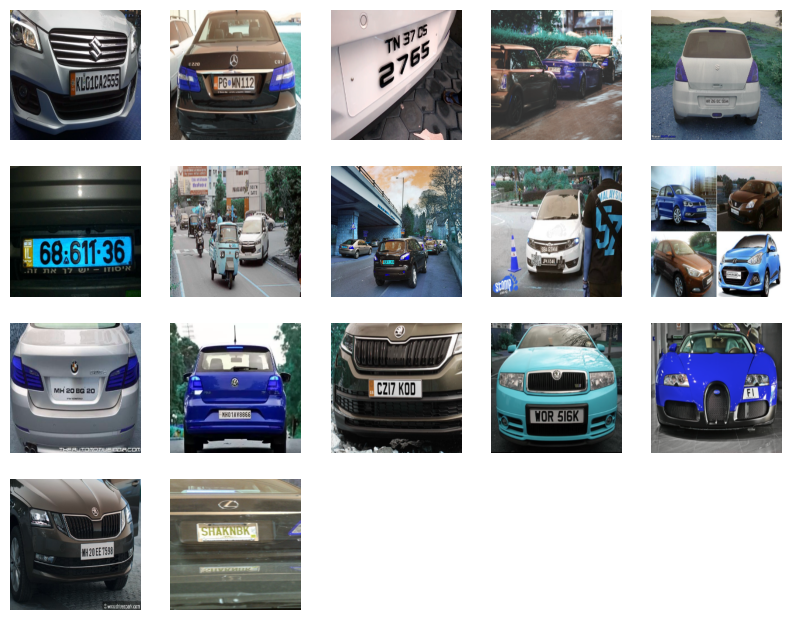

In [12]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

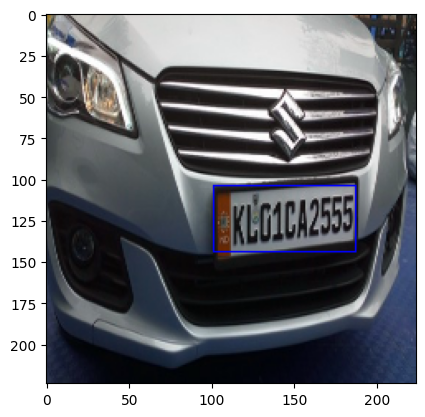

In [13]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


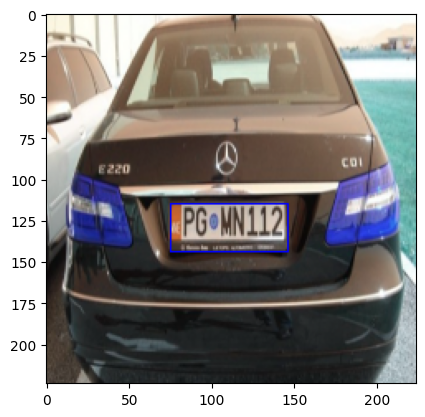

In [14]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [15]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [16]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [19]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [21]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.4283 - loss: 0.0656 - val_accuracy: 0.4857 - val_loss: 0.0216
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - accuracy: 0.5551 - loss: 0.0173 - val_accuracy: 0.6286 - val_loss: 0.0177
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3971s 434s/step - accuracy: 0.6774 - loss: 0.0093 - val_accuracy: 0.6000 - val_loss: 0.0149
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.8209 - loss: 0.0035 - val_accuracy: 0.7143 - val_loss: 0.0160
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 94s 10s/step - accuracy: 0.8414 - loss: 0.0026 - val_accuracy: 0.5429 - val_loss: 0.0151
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - accuracy: 0.8743 - loss: 0.0013 - val_accuracy: 0.6857 - val_loss: 0.0151
Epoch 7/50
 2/10 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.8984 - loss: 9.1235e-04

In [ ]:
model.save('my_model.h5', overwrite=True) 

In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 87.36%


In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

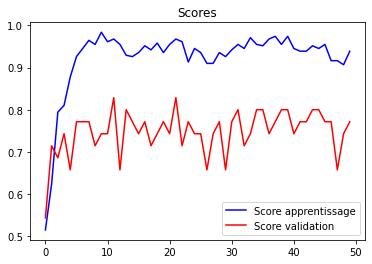

In [ ]:
plot_scores(train)

## DETECTION 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


 87/100 [=========================>....] - 1s 6ms/step - loss: 0.0066 - accuracy: 0.8736
Test results 
 Loss: 0.006622105371206999 
 Accuracy 0.8735632300376892


In [ ]:
y_cnn = model.predict(X_test)

We can see how our model localize license plates on our testing set :

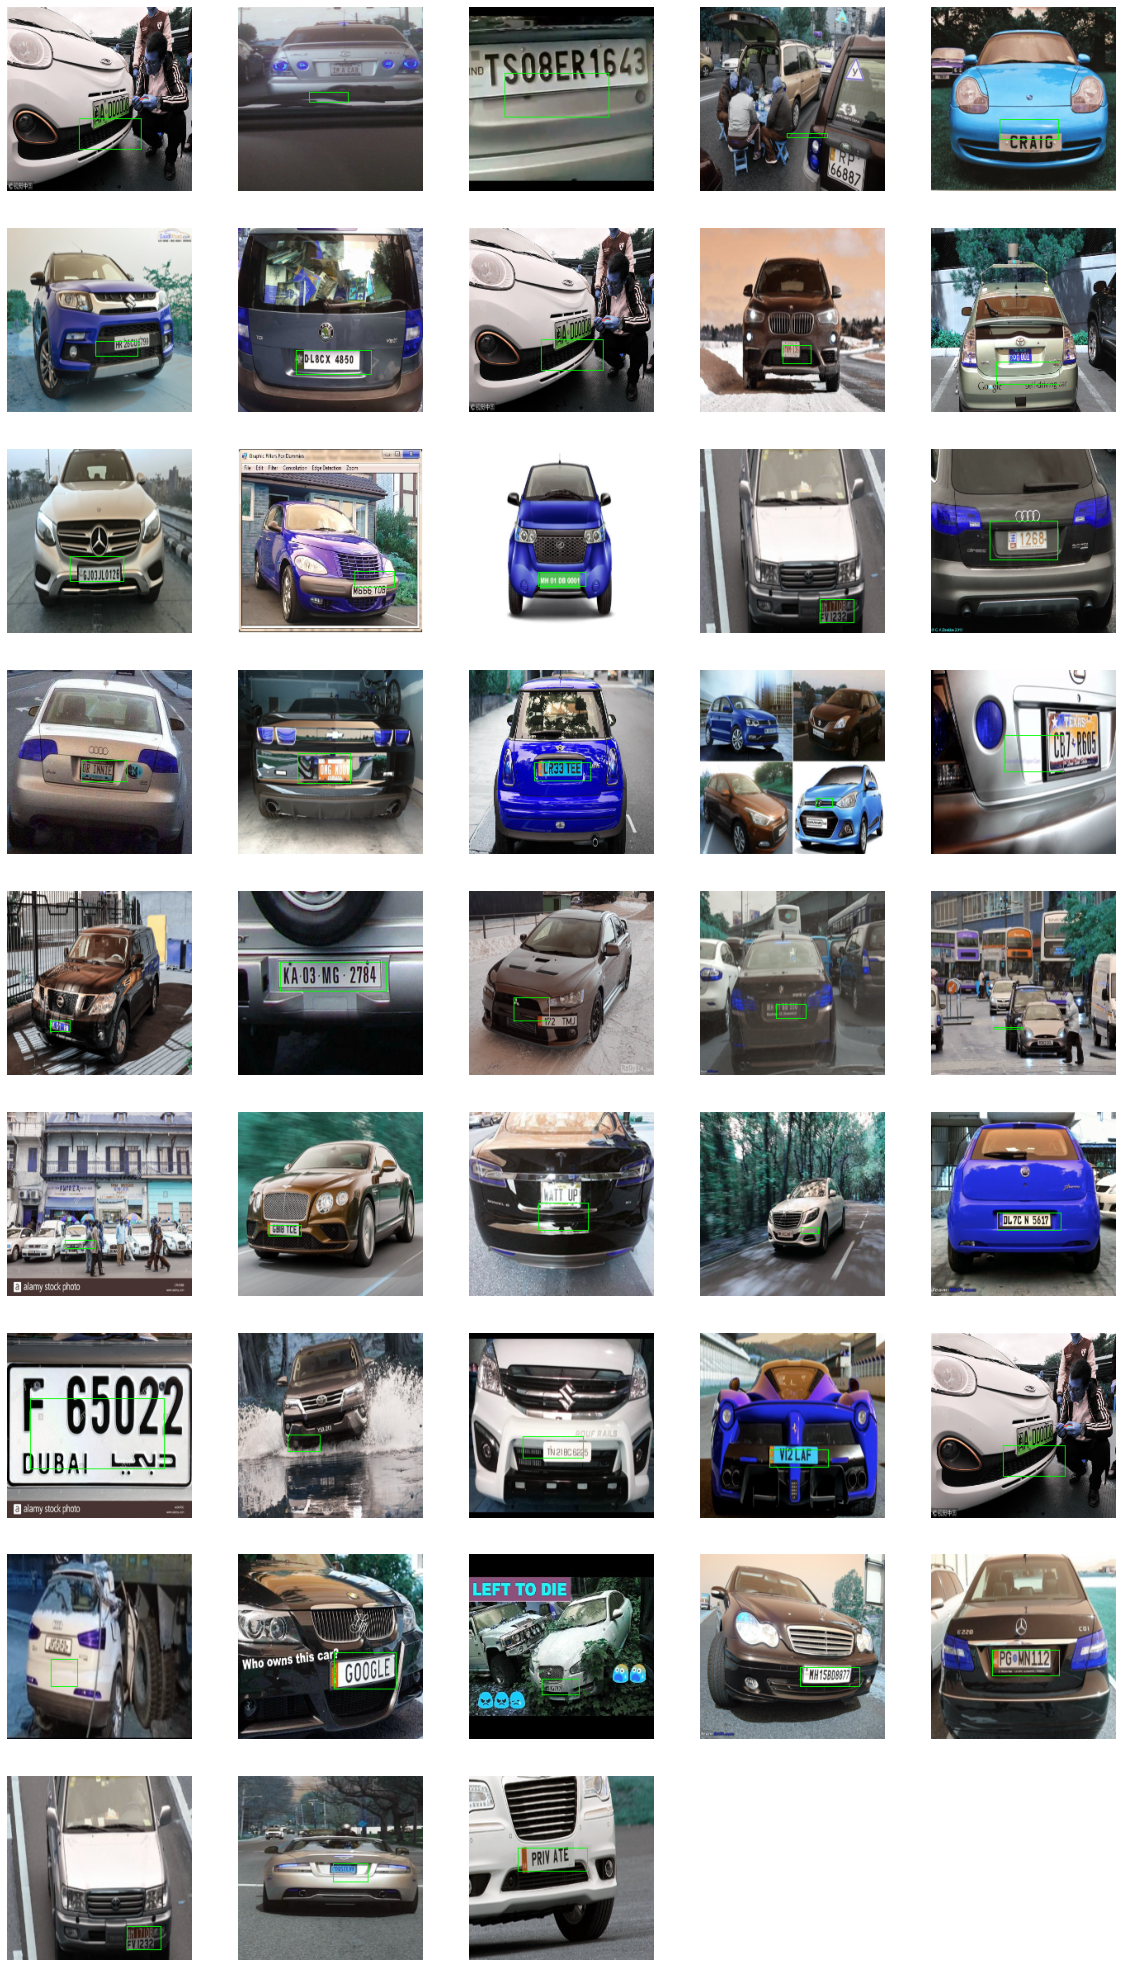

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)



In [ ]:
import tensorflow as tf
print(tf.__version__)  # Phiên bản TensorFlow
print(tf.keras.__version__)  # Phiên bản Keras tích hợp trong TensorFlow

2.3.0
2.4.0
